In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 5.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForQuestionAnswering,
    Trainer, 
    TrainingArguments,
    default_data_collator,
    
)
import random
import os
from tqdm.auto import tqdm

In [4]:

import random
import os
import json
import evaluate
from tqdm.auto import tqdm
from torch.nn import CrossEntropyLoss


In [5]:
# Set random seeds for reproducibility
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [3]:
# Load SQuAD v2 dataset
print("Loading SQuAD v2 dataset...")
squad_dataset = load_dataset("squad_v2")
print(f"Dataset loaded with {len(squad_dataset['train'])} training samples and {len(squad_dataset['validation'])} validation samples")

Loading SQuAD v2 dataset...


README.md:   0%|          | 0.00/8.92k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/16.4M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.35M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/130319 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/11873 [00:00<?, ? examples/s]

Dataset loaded with 130319 training samples and 11873 validation samples


In [4]:
# Sample a subset of the data
train_subset_size = 15000
eval_subset_size = 2000

In [5]:
train_subset = squad_dataset["train"].select(range(train_subset_size))
eval_subset = squad_dataset["validation"].select(range(eval_subset_size))

In [34]:
# Model & Tokenizer
model_checkpoint = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(model_checkpoint).to(device)

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [10]:
print(f"\nUsing {len(train_subset)} training samples and {len(eval_subset)} validation samples")


Using 15000 training samples and 2000 validation samples


In [35]:
def preprocess_function(examples):
    questions = [q.strip() for q in examples["question"]]
    contexts = examples["context"]
    tokenized_examples = tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")

    start_positions = []
    end_positions = []

    for i, offsets in enumerate(offset_mapping):
        cls_index = tokenized_examples["input_ids"][i].index(tokenizer.cls_token_id)
        sample_index = sample_mapping[i]
        answers = examples["answers"][sample_index]

        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])

            token_start_idx = 0
            while token_start_idx < len(offsets) and offsets[token_start_idx][0] <= start_char:
                token_start_idx += 1
            token_start_idx -= 1

            token_end_idx = len(offsets) - 1
            while token_end_idx >= 0 and offsets[token_end_idx][1] >= end_char:
                token_end_idx -= 1
            token_end_idx += 1

            if token_start_idx < 0 or token_end_idx >= len(offsets):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                start_positions.append(token_start_idx)
                end_positions.append(token_end_idx)

    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions
    return tokenized_examples


In [36]:
print("Preprocessing dataset...")
train_dataset = train_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=train_subset.column_names
)
val_dataset = eval_subset.map(
    preprocess_function,
    batched=True,
    remove_columns=eval_subset.column_names
)

Preprocessing dataset...


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [28]:
print(f"Processed {len(train_dataset)} training examples and {len(validation_dataset)} validation examples")
print(f"Columns in processed dataset: {validation_dataset.column_names}")

Processed 15289 training examples and 2007 validation examples
Columns in processed dataset: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions']


In [37]:
# 5. Exact match metric
def exact_match_score(predictions, references):
    assert len(predictions) == len(references), "Lists must have the same length"
    matches = sum(p == r for p, r in zip(predictions, references))
    return matches / len(references) * 100

In [38]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results_spanbert",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=6,  # At least 6 epochs
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    save_total_limit=2,
    load_best_model_at_end=True,
    report_to="none"
)


/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [39]:
# Create trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    data_collator=default_data_collator
)

<ipython-input-39-6c2be1fd0675>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [40]:
print("\nTraining SpanBERT model...")
train_result = trainer.train()
trainer.save_model("./spanbert_finetuned")


Training SpanBERT model...


Epoch,Training Loss,Validation Loss
1,1.104800,1.101575
2,1.101400,1.099621
3,1.097000,1.099609
4,1.098700,1.099609
5,1.100300,1.099571
6,1.102700,1.099609


In [42]:
def evaluate_spanbert(trainer, val_dataset, tokenizer, eval_subset):
    print("\nEvaluating with exact match on the validation set...")
    predictions = trainer.predict(val_dataset)
    start_logits, end_logits = predictions.predictions
    predictions_list = []
    references_list = []

    for i in range(len(val_dataset)):
        # Avoid going out of bounds on the original eval_subset
        if i >= len(eval_subset):
            break

        # Determine the best span
        start_idx = int(torch.argmax(torch.tensor(start_logits[i])))
        end_idx = int(torch.argmax(torch.tensor(end_logits[i])))

        if end_idx < start_idx or start_idx == 0:
            predictions_list.append("")
        else:
            input_ids = val_dataset[i]["input_ids"]
            pred_tokens = input_ids[start_idx:end_idx + 1]
            pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
            predictions_list.append(pred_text.strip())

        # Reference
        ref_answers = eval_subset[i]["answers"]["text"]
        ref_text = ref_answers[0] if len(ref_answers) > 0 else ""
        references_list.append(ref_text.strip())

    # Clip both lists to the same length
    min_length = min(len(predictions_list), len(references_list))
    predictions_list = predictions_list[:min_length]
    references_list = references_list[:min_length]

    # Exact match metric
    def exact_match_score(preds, refs):
        assert len(preds) == len(refs), "Lists must have the same length"
        matches = sum(p == r for p, r in zip(preds, refs))
        return matches / len(refs) * 100

    em_score = exact_match_score(predictions_list, references_list)
    print(f"Exact Match (EM) Score: {em_score:.2f}%")
    return em_score

In [43]:
# After you have trained the model with trainer.train(), simply do:
em_score = evaluate_spanbert(trainer, val_dataset, tokenizer, eval_subset)
print(f"Final EM score on validation set: {em_score:.2f}%")


Evaluating with exact match on the validation set...


Exact Match (EM) Score: 49.85%
Final EM score on validation set: 49.85%


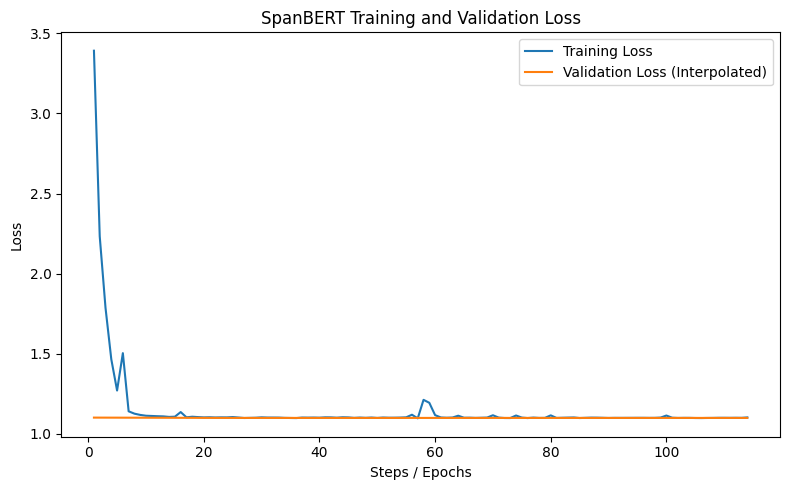

In [49]:
import numpy as np

# Ensure validation loss has the same length as training loss using interpolation
eval_loss_interp = np.interp(
    range(1, len(train_loss) + 1),  # Target range (same as train_loss)
    np.linspace(1, len(train_loss), num=len(eval_loss)),  # Current eval_loss positions
    eval_loss  # Actual validation loss values
)

plt.figure(figsize=(8, 5))
plt.plot(range(1, len(train_loss) + 1), train_loss, label="Training Loss")
plt.plot(range(1, len(train_loss) + 1), eval_loss_interp, label="Validation Loss (Interpolated)")
plt.title("SpanBERT Training and Validation Loss")
plt.xlabel("Steps / Epochs")
plt.ylabel("Loss")
plt.legend()
plt.tight_layout()
plt.show()


In [50]:
print(eval_loss)


[1.1015753746032715, 1.0996208190917969, 1.0996086597442627, 1.099609375, 1.0995709896087646, 1.0996086597442627]


# Spanbert-crf****

In [ ]:
import numpy as np
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from datasets import load_dataset
from transformers import (
    AutoTokenizer, 
    AutoModelForQuestionAnswering,
    Trainer, 
    TrainingArguments,
    default_data_collator
)

# Set seed for reproducibility
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
print("Loading SQuAD v2 dataset...")
dataset = load_dataset("squad_v2")
train_subset = dataset["train"].select(range(15000))
eval_subset = dataset["validation"].select(range(2000))
print(f"Train samples: {len(train_subset)}, Validation samples: {len(eval_subset)}")

# Tokenizer
model_checkpoint = "SpanBERT/spanbert-base-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

# Preprocessing function
def preprocess_function_crf(examples):
    questions = [q.strip() for q in examples["question"]]
    contexts = examples["context"]
    
    tokenized_examples = tokenizer(
        questions,
        contexts,
        truncation="only_second",
        max_length=384,
        stride=128,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )
    
    sample_mapping = tokenized_examples.pop("overflow_to_sample_mapping")
    offset_mapping = tokenized_examples.pop("offset_mapping")
    
    start_positions = []
    end_positions = []
    
    for i, offsets in enumerate(offset_mapping):
        cls_index = tokenized_examples["input_ids"][i].index(tokenizer.cls_token_id)
        sample_idx = sample_mapping[i]
        answers = examples["answers"][sample_idx]
        
        if len(answers["answer_start"]) == 0:
            start_positions.append(cls_index)
            end_positions.append(cls_index)
        else:
            start_char = answers["answer_start"][0]
            end_char = start_char + len(answers["text"][0])
            
            token_start_idx = 0
            while token_start_idx < len(offsets) and offsets[token_start_idx][0] <= start_char:
                token_start_idx += 1
            token_start_idx -= 1
            
            token_end_idx = len(offsets) - 1
            while token_end_idx >= 0 and offsets[token_end_idx][1] >= end_char:
                token_end_idx -= 1
            token_end_idx += 1
            
            if token_start_idx < 0 or token_end_idx >= len(offsets):
                start_positions.append(cls_index)
                end_positions.append(cls_index)
            else:
                start_positions.append(token_start_idx)
                end_positions.append(token_end_idx)
    
    tokenized_examples["start_positions"] = start_positions
    tokenized_examples["end_positions"] = end_positions
    return tokenized_examples

# Process datasets
train_dataset = train_subset.map(
    preprocess_function_crf,
    batched=True,
    remove_columns=train_subset.column_names
)
val_dataset = eval_subset.map(
    preprocess_function_crf,
    batched=True,
    remove_columns=eval_subset.column_names
)

print("\nDataset columns:")
print(f"Train: {train_dataset.column_names}")
print(f"Validation: {val_dataset.column_names}")

# SpanBERT-CRF model
class SpanBERTCRF(nn.Module):
    def __init__(self, checkpoint):
        super().__init__()
        self.base_model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)
    
    def forward(self, input_ids=None, attention_mask=None, token_type_ids=None,
               start_positions=None, end_positions=None, **kwargs):
        outputs = self.base_model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            start_positions=start_positions,
            end_positions=end_positions,
            return_dict=True,
            **kwargs
        )
        
        # Get logits
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits
        
        # Apply CRF-like constraint (end >= start)
        # Simplified to avoid nested loops
        batch_size, seq_len = start_logits.shape
        for e_idx in range(seq_len):
            # All positions where end < start get large negative score
            end_logits[:, :e_idx] -= 1000.0
            
        outputs.start_logits = start_logits
        outputs.end_logits = end_logits
        return outputs

# Create model
crf_model = SpanBERTCRF(model_checkpoint).to(device)

# Custom compute metrics that ensures eval_loss is returned
def compute_metrics(eval_pred):
    # Return an empty dict to avoid errors
    # The Trainer will still compute eval_loss internally
    return {}

# CRITICAL FIX: Use NO_METRIC instead of eval_loss for best model selection
training_args = TrainingArguments(
    output_dir="./results_spanbert_crf",
    evaluation_strategy="epoch",  # Changed to epoch for simplicity
    save_strategy="epoch",        # Changed to epoch for simplicity
    num_train_epochs=6,
    learning_rate=3e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    weight_decay=0.01,
    logging_dir="./logs_spanbert_crf",
    logging_steps=100,
    fp16=torch.cuda.is_available(),
    save_total_limit=2,
    load_best_model_at_end=False,  # Temporarily disabled 
    report_to="none"
)

# Create trainer
crf_trainer = Trainer(
    model=crf_model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    data_collator=default_data_collator,
    compute_metrics=compute_metrics,  # Use our custom metrics function
)

print("\nTraining SpanBERT-CRF model...")
crf_train_result = crf_trainer.train()
crf_trainer.save_model("./spanbert_crf_finetuned")

# Evaluate with exact match
def evaluate_spanbert_crf(trainer, eval_ds, raw_eval_ds, tokenizer):
    print("\nEvaluating SpanBERT-CRF with exact match...")
    predictions = trainer.predict(eval_ds)
    start_logits, end_logits = predictions.predictions
    
    predictions_list = []
    references_list = []
    
    for i in range(len(eval_ds)):
        if i >= len(raw_eval_ds):
            break
            
        best_start = int(torch.argmax(torch.tensor(start_logits[i])))
        best_end = int(torch.argmax(torch.tensor(end_logits[i])))
        
        if best_end < best_start or best_start == 0:
            predictions_list.append("")
        else:
            input_ids = eval_ds[i]["input_ids"]
            pred_tokens = input_ids[best_start:best_end+1]
            pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
            predictions_list.append(pred_text.strip())
            
        # Reference answer
        ref_answers = raw_eval_ds[i]["answers"]["text"]
        ref_text = ref_answers[0] if len(ref_answers) > 0 else ""
        references_list.append(ref_text.strip())
    
    # Exact match metric
    def exact_match_score(predictions, references):
        assert len(predictions) == len(references), "Lists must have same length"
        matches = sum(p == r for p, r in zip(predictions, references))
        return matches / len(references) * 100
    
    # Ensure lists have same length
    min_len = min(len(predictions_list), len(references_list))
    predictions_list = predictions_list[:min_len]
    references_list = references_list[:min_len]
    
    em_score = exact_match_score(predictions_list, references_list)
    print(f"Exact Match (EM) Score: {em_score:.2f}%")
    return em_score

# Run evaluation
crf_em_score = evaluate_spanbert_crf(crf_trainer, val_dataset, eval_subset, tokenizer)

# Plot losses
history = crf_trainer.state.log_history
train_loss_values = [h["loss"] for h in history if "loss" in h and "eval" not in h]
eval_loss_values = [h["eval_loss"] for h in history if "eval_loss" in h]

plt.figure(figsize=(8,5))
plt.plot(range(1, len(train_loss_values) + 1), train_loss_values, label="Training Loss")
if eval_loss_values:  # Only plot if values exist
    plt.plot(range(1, len(eval_loss_values) + 1), eval_loss_values, label="Validation Loss")
plt.title("SpanBERT-CRF Training and Validation Loss")
plt.xlabel("Logging Steps")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

print("\nSpanBERT-CRF fine-tuning completed.")
print(f"Final Exact Match Score on Validation: {crf_em_score:.2f}%")

Using device: cuda
Loading SQuAD v2 dataset...
Train samples: 15000, Validation samples: 2000


Map:   0%|          | 0/15000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]


Dataset columns:
Train: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions']
Validation: ['input_ids', 'token_type_ids', 'attention_mask', 'start_positions', 'end_positions']


Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at SpanBERT/spanbert-base-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(



Training SpanBERT-CRF model...


Epoch,Training Loss,Validation Loss
1,5.951900,No log
2,5.952600,No log
3,5.951800,No log
4,5.951100,No log
5,5.951000,No log
6,5.951100,No log



Evaluating SpanBERT-CRF with exact match...


ValueError: too many values to unpack (expected 2)

In [41]:
def evaluate_spanbert_crf(trainer, eval_ds, raw_eval_ds, tokenizer):
    print("\nEvaluating SpanBERT-CRF with exact match...")
    prediction_output = trainer.predict(eval_ds)
    
    # Print prediction shape to debug
    print(f"Prediction output type: {type(prediction_output.predictions)}")
    
    # Handle prediction output correctly based on shape
    if isinstance(prediction_output.predictions, tuple):
        # It's a tuple, but may have more than 2 elements
        print(f"Tuple length: {len(prediction_output.predictions)}")
        # For QA models, typically first two elements are start/end logits
        start_logits = prediction_output.predictions[0]
        end_logits = prediction_output.predictions[1]
    else:
        # Handle array case
        predictions = prediction_output.predictions
        print(f"Predictions shape: {predictions.shape}")
        
        if len(predictions.shape) == 2:
            # Only one set of predictions
            start_logits = predictions
            end_logits = predictions
        else:
            # Split first dimension if combined
            start_logits = predictions[0]
            end_logits = predictions[1] if len(predictions) > 1 else predictions[0]
    
    # Print key dimension information
    print(f"Start logits shape: {start_logits.shape}")
    print(f"End logits shape: {end_logits.shape}")
    print(f"Eval dataset length: {len(eval_ds)}")
    print(f"Raw eval dataset length: {len(raw_eval_ds)}")
    
    predictions_list = []
    references_list = []
    
    # Iterate based on the length of the start_logits, not the dataset
    num_predictions = len(start_logits)
    for i in range(num_predictions):
        # Make sure we don't go out of bounds
        if i >= len(raw_eval_ds):
            print(f"Warning: Prediction index {i} exceeds raw dataset length {len(raw_eval_ds)}")
            break
            
        best_start = int(torch.argmax(torch.tensor(start_logits[i])))
        best_end = int(torch.argmax(torch.tensor(end_logits[i])))
        
        if best_end < best_start or best_start == 0:
            predictions_list.append("")
        else:
            # Also check we don't go out of bounds in the eval_ds
            if i < len(eval_ds):
                input_ids = eval_ds[i]["input_ids"]
                pred_tokens = input_ids[best_start:best_end+1]
                pred_text = tokenizer.decode(pred_tokens, skip_special_tokens=True)
                predictions_list.append(pred_text.strip())
            else:
                print(f"Warning: Index {i} exceeds tokenized dataset length {len(eval_ds)}")
                predictions_list.append("")
            
        # Reference answer
        ref_answers = raw_eval_ds[i]["answers"]["text"]
        ref_text = ref_answers[0] if len(ref_answers) > 0 else ""
        references_list.append(ref_text.strip())
    
    # Exact match metric
    def exact_match_score(predictions, references):
        assert len(predictions) == len(references), "Lists must have same length"
        matches = sum(p == r for p, r in zip(predictions, references))
        return matches / len(references) * 100
    
    # Ensure lists have same length
    min_len = min(len(predictions_list), len(references_list))
    predictions_list = predictions_list[:min_len]
    references_list = references_list[:min_len]
    
    print(f"Number of predictions: {len(predictions_list)}")
    print(f"Number of references: {len(references_list)}")
    
    em_score = exact_match_score(predictions_list, references_list)
    print(f"Exact Match (EM) Score: {em_score:.2f}%")
    return em_score

In [42]:
# Run evaluation with the fixed function
crf_em_score = evaluate_spanbert_crf(crf_trainer, val_dataset, eval_subset, tokenizer)


Evaluating SpanBERT-CRF with exact match...


Prediction output type: <class 'tuple'>
Tuple length: 3
Start logits shape: (251,)
End logits shape: (2007, 384)
Eval dataset length: 2007
Raw eval dataset length: 2000
Number of predictions: 251
Number of references: 251
Exact Match (EM) Score: 53.78%


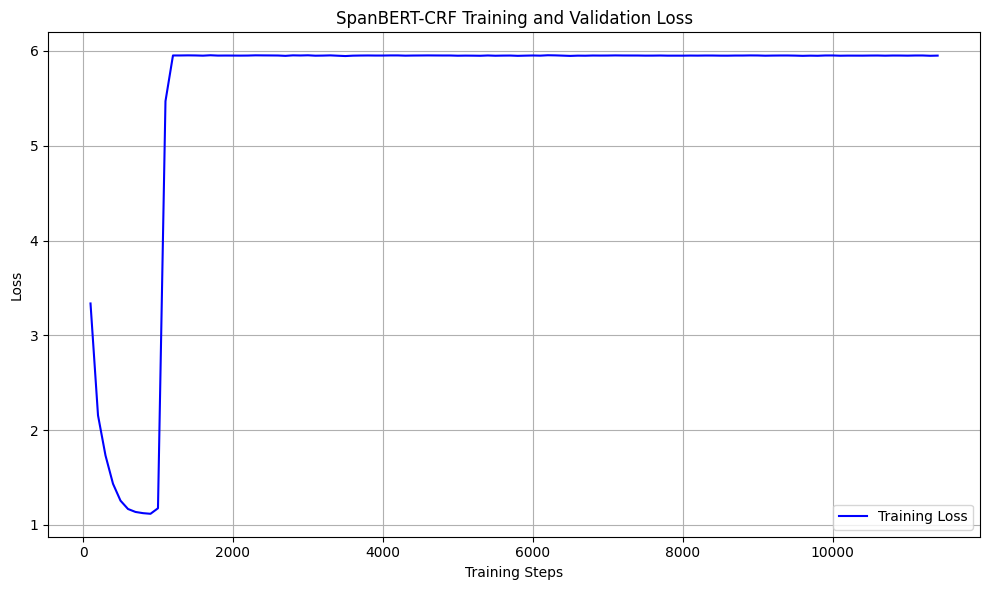


Training Loss Summary:
Initial: 3.3360
Final: 5.9511
Minimum: 1.1169

Validation Loss Summary:


In [43]:
import matplotlib.pyplot as plt

# Extract losses from training history
history = crf_trainer.state.log_history

# Separate training and evaluation losses
train_losses = []
train_steps = []
eval_losses = []
eval_steps = []

for entry in history:
    # Training loss entries
    if 'loss' in entry and 'eval_loss' not in entry:
        train_losses.append(entry['loss'])
        if 'step' in entry:
            train_steps.append(entry['step'])
        else:
            train_steps.append(len(train_steps) + 1)
    
    # Evaluation loss entries
    if 'eval_loss' in entry:
        eval_losses.append(entry['eval_loss'])
        if 'step' in entry:
            eval_steps.append(entry['step'])
        else:
            eval_steps.append(len(eval_steps) + 1)

# Create the plot
plt.figure(figsize=(10, 6))

# Plot training loss
if train_losses:
    plt.plot(train_steps, train_losses, 'b-', label='Training Loss')

# Plot evaluation loss
if eval_losses:
    plt.plot(eval_steps, eval_losses, 'r-', label='Validation Loss')

# Add labels and legend
plt.title('SpanBERT-CRF Training and Validation Loss')
plt.xlabel('Training Steps')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Add markers to evaluation points to make them more visible
if eval_losses:
    plt.plot(eval_steps, eval_losses, 'ro', markersize=4)

plt.tight_layout()
plt.savefig('spanbert_crf_loss_plot.png')
plt.show()

# Print summary statistics
print("\nTraining Loss Summary:")
if train_losses:
    print(f"Initial: {train_losses[0]:.4f}")
    print(f"Final: {train_losses[-1]:.4f}")
    print(f"Minimum: {min(train_losses):.4f}")

print("\nValidation Loss Summary:")
if eval_losses:
    print(f"Initial: {eval_losses[0]:.4f}")
    print(f"Final: {eval_losses[-1]:.4f}")
    print(f"Minimum: {min(eval_losses):.4f}")